# Time-averaged fluxes
## Question: How does heterogeneity, as demonstrated in the IR images at Snoqualmie, impact time-averaged fluxes? 

- Use the turbpy python package to answer this question in a synthetic study
- Prescribe two populations of surface temperature (tree and snow surfaces from IR images) and model the sensible heat flux. Compare that to the actual observed air and surface temperature values.

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import scipy

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import solargeo
import kgraph
import turbpy
import turbpy.multiConst as mc

## Directories

In [3]:
# Project directory
dir_proj = '/Users/karllapo/proj/SnowHydro_OfflineTurb'
dir_print = os.path.join(dir_proj, 'graphics')

# Data
dir_data = os.path.join(dir_proj, 'data')
dir_snq = os.path.join(dir_data, 'SNQ')
dir_scp = os.path.join(dir_data, 'SCP')

# Model output
dir_model_ouptut = os.path.join(dir_data, 'results')

## Plot customization

In [4]:
# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context(context)

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']

# This is only relevant if you have a retina screen
%config InlineBackend.figure_format = 'retina'

### Prescribe all boundary conditions except air temperature


In [27]:
air_temp = 283
windspd = 1.5
mHeight = 3.
snowDepth = 0.
(airVaporPress,_) = turbpy.satVapPress(air_temp)
(sfcVaporPress, _) = turbpy.satVapPress(273.)
airPressure = 101000.

# Graphing options
colr = kgraph.SRON(4)


In [50]:
stab_titles = ['Louis (b = 4.7)',
               'Louis (b = 12)',
               'Louis (Ri capped, MJ98)',
               ]

# Titles for output and xarray datasets
out_titles = {'Louis (b = 4.7)': 'louis',
              'Louis (b = 12)': 'louis_mod',
              'Louis (Ri capped, MJ98)': 'louis_cap',
              }

stab_methods = {'Louis (b = 4.7)': 'louis',
                'Louis (b = 12)': 'louis',
                'Louis (Ri capped, MJ98)': 'louis',
                }

axis_titles = {'Louis (b = 4.7)': 'Louis',
               'Louis (b = 12)': 'Louis (mod)',
               'Louis (Ri capped, MJ98)': 'Louis (capped)',
               }

params = {'Louis (b = 4.7)': 9.4,
          'Louis (Ri capped, MJ98)': 9.4,
          'Louis (b = 12)': 24.}

capping = {'Louis (Ri capped, MJ98)': 'louis_Ri_capping',
          }

# Initialize the multi-level parameter dictionary
stab_dict = {}
stab_dict['stability_params'] = {}

for st in stab_methods:
    stab_dict[st] = {}
    
    # Assigning the stability method
    stab_dict[st]['stability_method'] = stab_methods[st]        
    # Assiging the capping behavior
    if st in capping.keys():
        stab_dict[st]['capping'] = capping[st]
    
    # Determine stability params
    if st in params.keys():
        stab_dict[st]['stability_params'] = {stab_methods[st]: params[st]}
z0Ground = 0.005


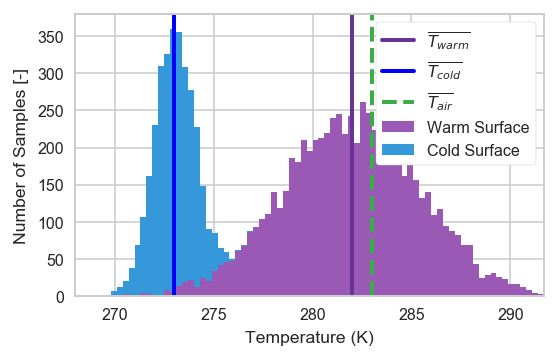

In [142]:
# Variables for defining the distributions
num_samples = 10000
delta_bins = 0.3
norm_flag = False

snow_sfc_mean = 273
snow_var = 1

tree_sfc_mean = 282
tree_var = 3.5

bins = np.arange(snow_sfc_mean - 5, tree_sfc_mean + 10, delta_bins)

# Weighting the snow and tree temps
snow_fraction = 0.3
num_snow = int(num_samples * snow_fraction)
num_tree = int(num_samples * (1 - snow_fraction))

# Calculate the temperature distributions
snow_temp = np.random.normal(snow_sfc_mean, snow_var, num_snow)
y_snow = scipy.stats.norm.pdf(bins, snow_sfc_mean, snow_var)

tree_temp = np.random.normal(tree_sfc_mean, tree_var, num_tree)
y_tree = scipy.stats.norm.pdf(bins, tree_sfc_mean, tree_var)

# Total population
y = y_tree + y_snow

# Bulk stability
RiBulk_snow = turbpy.bulkRichardson(air_temp, snow_temp, windspd, mHeight)
RiBulk_tree = turbpy.bulkRichardson(air_temp, tree_temp, windspd, mHeight)

# Plot these values for a quick visualization
fig, ax = plt.subplots(1,1, figsize=(4.2, 2.6))

# ax.plot(bins, y_tree * num_tree * delta_bins, 'r', linewidth=2, label='$T_{tree}$')
# ax.plot(bins, y_snow * num_snow * delta_bins, 'k', linewidth=2, label='$T_{snow}$')
# if norm_flag:
#     ax.plot(bins, y * num_samples * delta_bins, '--k', linewidth=2, label='$T_{total}$')

ax.hist([tree_temp, snow_temp], bins=bins, stacked=True, label=['Warm Surface', 'Cold Surface'], density=norm_flag)
ax.plot([tree_sfc_mean, tree_sfc_mean], [0, 380], color='#663399', linewidth=2, label='$\overline{T_{warm}}$')
ax.plot([snow_sfc_mean, snow_sfc_mean], [0, 380], color='b', linewidth=2, label='$\overline{T_{cold}}$')
ax.plot([air_temp, air_temp], [0, 380], '--', color=sns.xkcd_rgb["medium green"], linewidth=2, label='$\overline{T_{air}}$')

ax.legend(frameon=True, loc='upper right', framealpha=1)
ax.set_xlim(min(bins),max(bins))
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Number of Samples [-]')
ax.set_ylim(0, 380)

os.chdir(dir_print)
fig.savefig('CGsyn.temp_dist.sf_' + str(int(snow_fraction * 10)) + '.pdf', bbox_inches='tight')

### How does Ri behave with the synthetic dataset?

Text(0,0.5,'Count (n)')

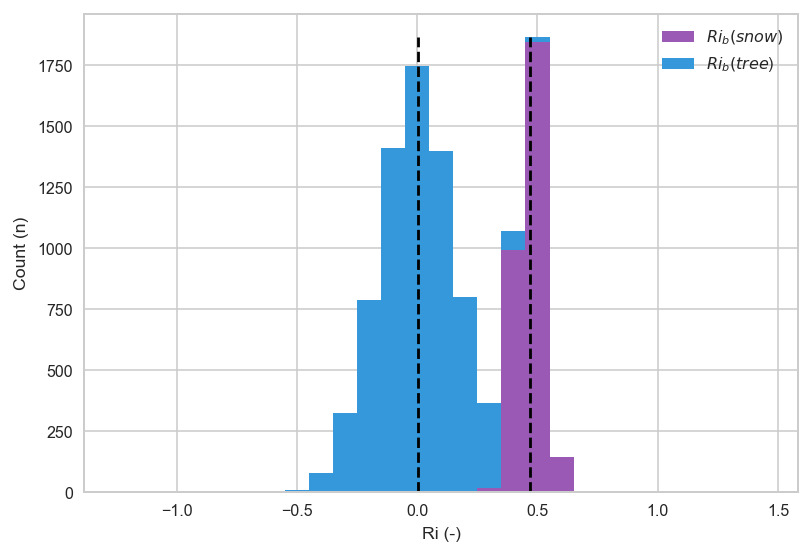

In [18]:
fig, ax = plt.subplots(1,1)

n, b, _ = ax.hist([RiBulk_snow, RiBulk_tree], bins=np.arange(-1.25, 1.5, .1),
                  stacked=True, label=['$Ri_b (snow)$','$Ri_b (tree$)']);
ax.plot([np.mean(RiBulk_snow),np.mean(RiBulk_snow)], [0, np.max(n)], 'k--')
ax.plot([np.mean(RiBulk_tree),np.mean(RiBulk_tree)], [0, np.max(n)], 'k--')

ax.legend()
ax.set_xlabel('Ri (-)')
ax.set_ylabel('Count (n)')

## Stability and related parameters

## Fluxes

In [106]:
# -------------------------------------------------------------------------------------------------------
# Snow temperature variability
# -------------------------------------------------------------------------------------------------------
sensible_snow = xr.Dataset()

for stab in stab_titles:
    outname = out_titles[stab]
    sensible = np.ones_like(snow_temp) * np.nan
    
    for n, temp in enumerate(snow_temp):
        # Offline turbulence
        (_, _, sensible[n], _, _, _) = turbpy.turbFluxes(air_temp,
                                                        airPressure,
                                                        airVaporPress,
                                                        windspd,
                                                        temp,
                                                        sfcVaporPress,
                                                        snowDepth,
                                                        mHeight,
                                                        groundSnowFraction=1,
                                                        param_dict=stab_dict[stab],
                                                        z0Ground=.005,
                                                        )

    sensible_snow[outname] = (('n'), sensible)


In [107]:
# -------------------------------------------------------------------------------------------------------
# Tree temperature variability
# -------------------------------------------------------------------------------------------------------
sensible_tree = xr.Dataset()

for stab in stab_titles:
    outname = out_titles[stab]
    sensible = np.ones_like(tree_temp) * np.nan
    
    for n, temp in enumerate(tree_temp):
        # Offline turbulence
        (_, _, sensible[n], _, _, _) = turbpy.turbFluxes(air_temp,
                                                        airPressure,
                                                        airVaporPress,
                                                        windspd,
                                                        temp,
                                                        sfcVaporPress,
                                                        snowDepth,
                                                        mHeight,
                                                        groundSnowFraction=1,
                                                        param_dict=stab_dict[stab],
                                                        z0Ground=.005,
                                                        )

    sensible_tree[outname] = (('n'), sensible)

## Fluxes
### PDF/Histogram distributions

Text(0.5,1,'b) $Q_{h}$ of tree population')

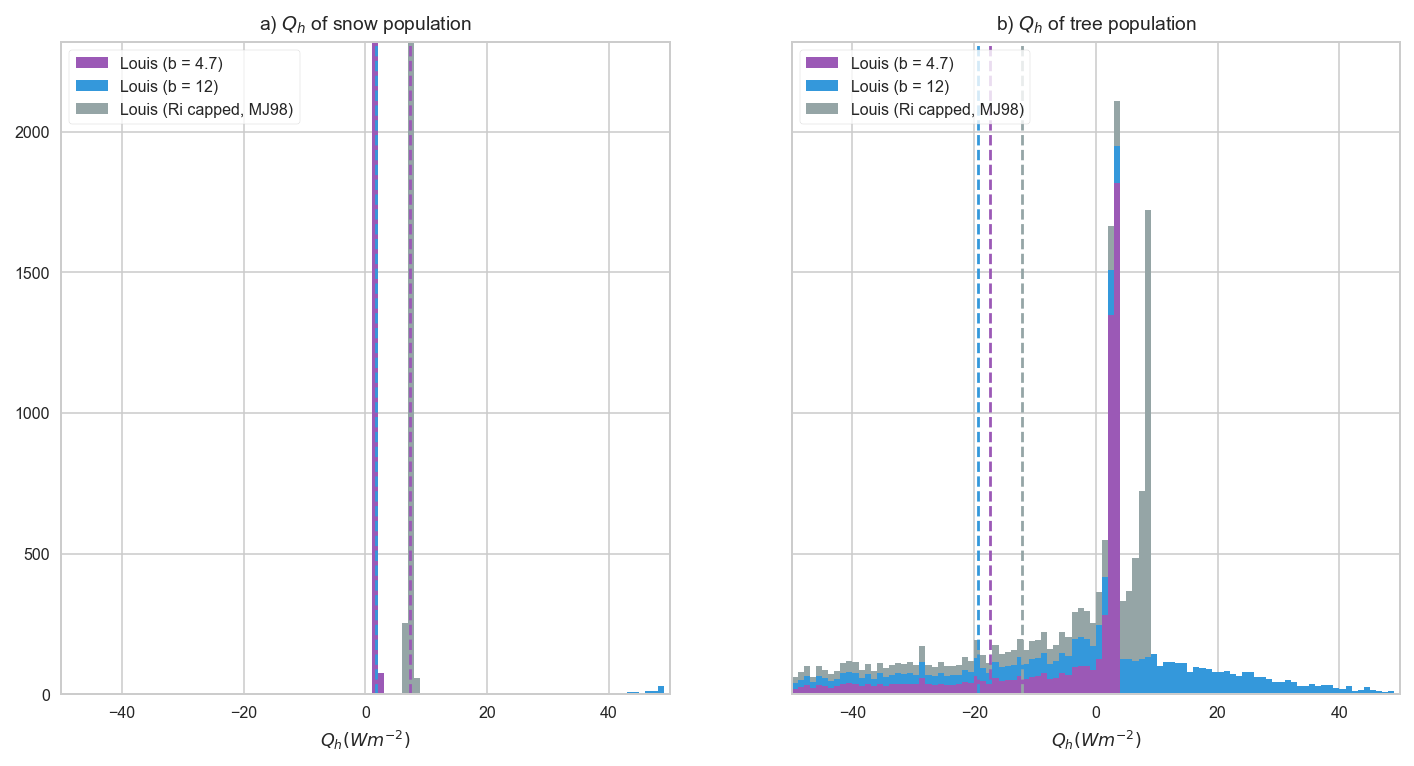

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex='row', sharey='row')

# -------------------------------------------------------------------------------------------------------
# Snow temperature variability
# -------------------------------------------------------------------------------------------------------
ax = axes[0]

# Histogram of each method 
counts, b, _ = ax.hist([sensible_snow['louis_mod'],
                   sensible_snow['louis_cap'],
                   sensible_snow['louis']],
                  bins=np.arange(-50, 50, 1), stacked=True, label=out_titles);

# Line indicating mean values
for n, stab in enumerate(stab_titles):
    name = out_titles[stab]
    ax.plot([sensible_snow[name].mean(dim='n'), sensible_snow[name].mean(dim='n')], [0, np.max(counts) + np.max(counts) / 10],
            '--', color=flatui[n])
ax.legend(loc='upper left', frameon=True)
ax.set_xlim(-50, 50)
ax.set_ylim(0, np.max(counts) + np.max(counts) / 10)
ax.set_xlabel('$Q_h (Wm^{-2})$')
ax.set_title('a) $Q_{h}$ of snow population')

# -------------------------------------------------------------------------------------------------------
# Tree temperature variability
# -------------------------------------------------------------------------------------------------------
ax = axes[1]
# Histogram of each method 
counts, b, _ = ax.hist([sensible_tree['louis_mod'],
                   sensible_tree['louis_cap'],
                   sensible_tree['louis']],
                  bins=np.arange(-50, 50, 1), stacked=True, label=out_titles);

# Line indicating mean values
for n, stab in enumerate(stab_titles):
    name = out_titles[stab]
    ax.plot([sensible_tree[name].mean(dim='n'), sensible_tree[name].mean(dim='n')],
            [0, np.max(counts) + np.max(counts) / 10], '--', color=flatui[n])
ax.legend(loc='upper left', frameon=True)
ax.set_xlim(-50, 50)
ax.set_ylim(0, np.max(counts) + np.max(counts) / 10)
ax.set_xlabel('$Q_h (Wm^{-2})$')
ax.set_title('b) $Q_{h}$ of tree population')


## Combined to get the mean flux

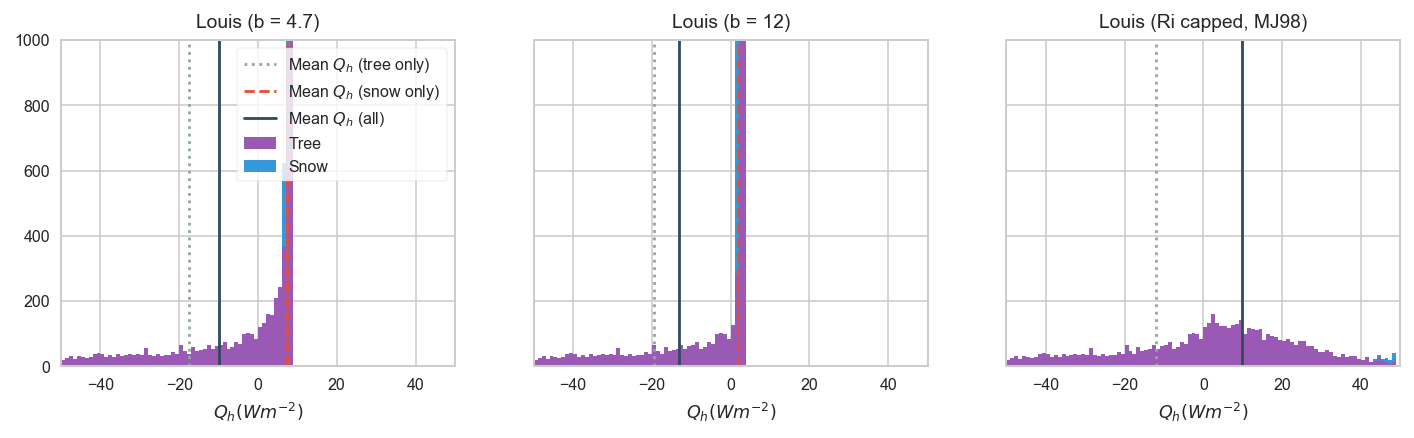

In [109]:
# -------------------------------------------------------------------------------------------------------
# Combined
# -------------------------------------------------------------------------------------------------------

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey='row', sharex='row')
for nstab, stab in enumerate(stab_titles):
    ax = axes[nstab]
    name = out_titles[stab]

    # Histogram of each method 
    counts, b, _ = ax.hist([sensible_tree[name], sensible_snow[name]],
                           bins=np.arange(-50, 50, 1), stacked=True, label=['Tree', 'Snow']);

    # Line indicating mean values
    counts = 1000
    ax.plot([sensible_tree[name].mean(dim='n'), sensible_tree[name].mean(dim='n')],
            [0, np.max(counts) + np.max(counts) / 10], ':', color=flatui[2], label='Mean $Q_h$ (tree only)')
    ax.plot([sensible_snow[name].mean(dim='n'), sensible_snow[name].mean(dim='n')],
            [0, np.max(counts) + np.max(counts) / 10], '--', color=flatui[3], label='Mean $Q_h$ (snow only)')
    
    mean_surface_qh = np.mean(np.concatenate((sensible_snow[name], sensible_tree[name]), axis=0))
    ax.plot([mean_surface_qh, mean_surface_qh],
            [0, np.max(counts) + np.max(counts) / 10], '-', color=flatui[4], label='Mean $Q_h$ (all)')
    
    ax.set_xlabel('$Q_h (Wm^{-2})$')
    ax.set_title(stab)

ax.set_xlim(-50, 50)
ax.set_ylim(0, counts)
axes[0].legend(loc='upper right', frameon=True)


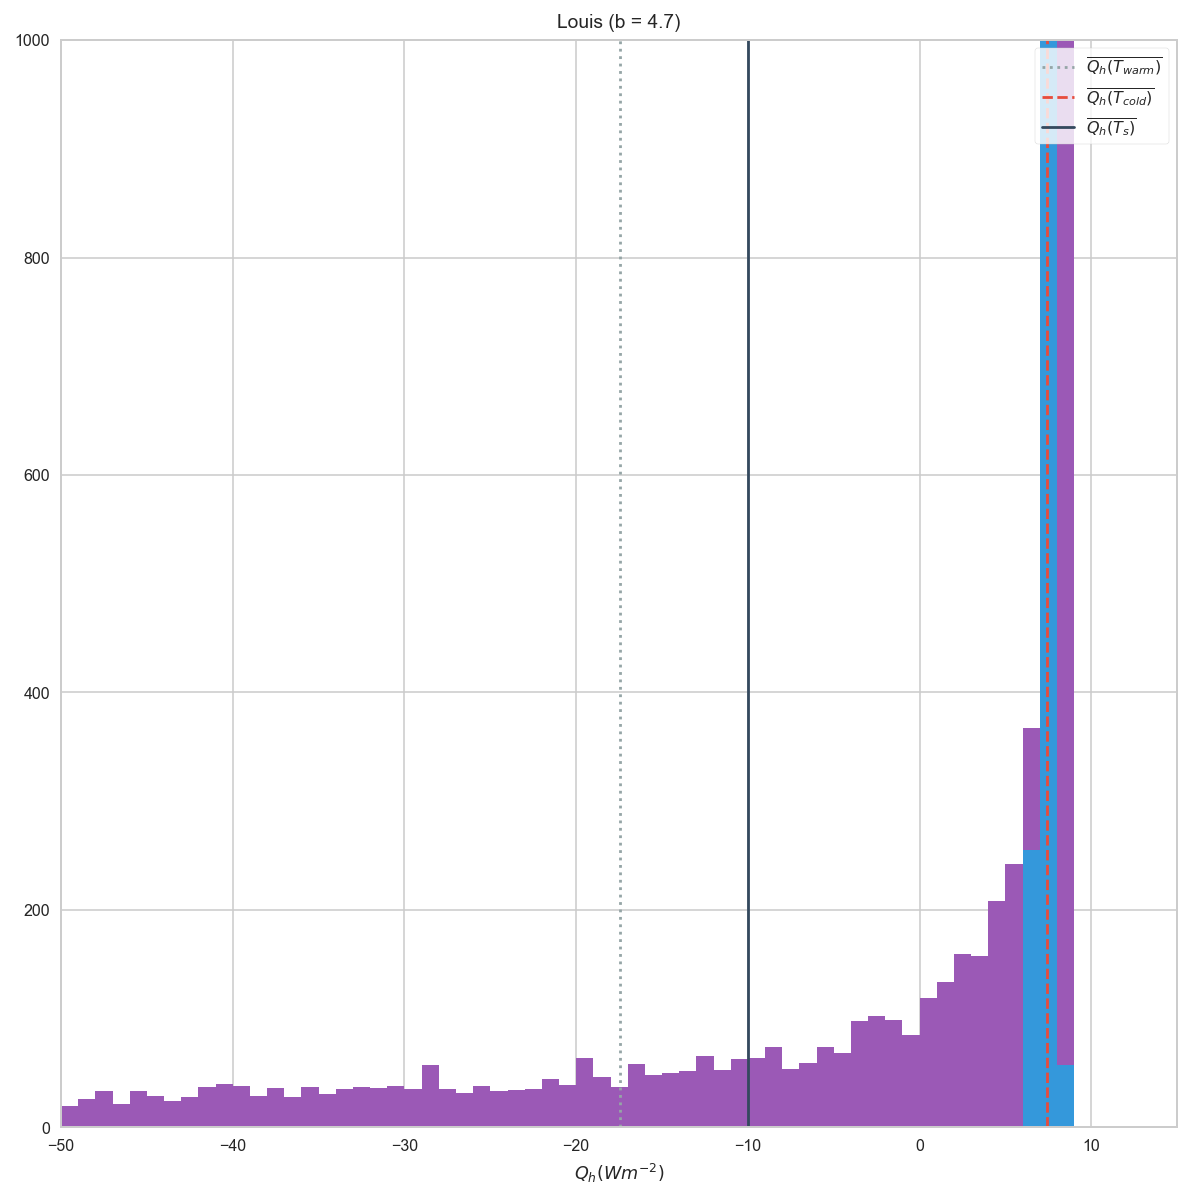

In [132]:
# -------------------------------------------------------------------------------------------------------
# Combined
# -------------------------------------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
stab = 'Louis (b = 4.7)'
name = out_titles[stab]

# Histogram of each method 
counts, b, _ = ax.hist(sensible_tree[name].values,
                       bins=np.arange(-50, 25, 1), stacked=True);
# Histogram of each method 
counts, b, _ = ax.hist(sensible_snow[name].values,
                       bins=np.arange(-50, 25, 1), stacked=True);

# Line indicating mean values
counts = 1000
ax.plot([sensible_tree[name].mean(dim='n'), sensible_tree[name].mean(dim='n')],
        [0, np.max(counts) + np.max(counts) / 10], ':', color=flatui[2], label='$\overline{Q_h (T_{warm})}$')
ax.plot([sensible_snow[name].mean(dim='n'), sensible_snow[name].mean(dim='n')],
        [0, np.max(counts) + np.max(counts) / 10], '--', color=flatui[3], label='$\overline{Q_h (T_{cold})}$')

mean_surface_qh = np.mean(np.concatenate((sensible_snow[name], sensible_tree[name]), axis=0))
ax.plot([mean_surface_qh, mean_surface_qh],
        [0, np.max(counts) + np.max(counts) / 10], '-', color=flatui[4], label='$\overline{Q_h (T_{s})}$')

ax.set_xlabel('$Q_h (Wm^{-2})$')
ax.set_title(stab)

ax.set_xlim(-50, 15)
ax.set_ylim(0, counts)
ax.legend(loc='upper right', frameon=True)


In [124]:
np.shape(np.vstack((sensible_tree[name].values, sensible_snow[name].values)))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

So this is a little confusing. Let's brake it down. 

a) Standard and Louis  
The standard and Louis methods generate a mean flux that goes to zero with a snow fraction of 30%. This makes intuitive sense as the mean flux is approximately zero for the stable case over snow with these methods -- the mean flux is dominated by the "tree" flux. 

b) Mahrt  
The mean Mahrt flux is approximately zero. This also makes intuitive sense. The Mahrt method generates an overly large sensible heat flux for very stable conditions. The stable conditions are therefor disproportionately weighted in this case. 

c) Monin-Obukhov with capping  
The Monin-Obukhov method with capping has a slightly positive flux. This is because of the effect of the conductance capping keeping the sensible heat flux during stable conditions large and non-zero and the different conductance the method has for unstable conditions compared to the other three methods.

The purpose of this study was not to study turbulence during stable conditions, but here we are finding out that the way these two cases (stable and unstable) interact for a landscape with a heterogenous surface temperature may have an impact of the estimate turbulence during locally stable conditions.

Of couse, this synthetic study is only considering the impact of heterogeneous surface temperatures on modeled turbulence from a large-scale perspective and may not represent the physics occurring in reality. For instance, at SNQ during the period with counter-gradient fluxes depicted in the paper, the counter-gradient fluxes may just be purely because the wind direction comes from the highway/trees and the footprint of the CSAT does not include any meaningful amount of interaction with snow-covered surfaces. How to represent this situation in a modeling framework is beyond me.

## Fluxes as a function of "fractional snow cover"

In [44]:
# Variables for defining the distributions
num_samples = 10000
delta_bins = 0.3

snow_sfc_mean = 273
snow_var = 1

tree_sfc_mean = 283
tree_var = 3.5

bins = np.arange(snow_sfc_mean - 5, tree_sfc_mean + 10, delta_bins)

# -------------------------------------------------------------------------------------------------------
# Sensible heat flux calculation
# -------------------------------------------------------------------------------------------------------
sensible_snow_fract = xr.Dataset()
sensible_tree_fract = xr.Dataset()

snow_fraction = np.arange(0, 1.1, 0.1)

# Mean sensible heat flux from the distribution of temperatures
sensible_fract_mean = np.zeros((np.size(snow_fraction), 4))
# Mean sensible heat flux from the mean of the temperature distributions
sensible_mean_tsrf = np.zeros((np.size(snow_fraction), 4))

for n_sf, sf in enumerate(snow_fraction):
    print('Snow_fraction = ' + str(sf))
    # Weighting the snow and tree temps
    num_snow = int(num_samples * sf)
    num_tree = int(num_samples * (1 - sf))

    # Calculate the temperature distributions
    snow_temp = np.random.normal(snow_sfc_mean, snow_var, num_snow)
    tree_temp = np.random.normal(tree_sfc_mean, tree_var, num_tree)

    for nstab, stab in enumerate(stab_titles):
        name = out_titles[stab]
        sensible_s = np.ones_like(snow_temp) * np.nan
        sensible_t = np.ones_like(tree_temp) * np.nan
    
        # Offline turbulence
        for n, temp in enumerate(snow_temp):
            # Offline turbulence
            (_, _, sensible_s[n], _, _, _) = turbpy.turbFluxes(air_temp,
                                                               airPressure,
                                                               airVaporPress,
                                                               windspd,
                                                               temp,
                                                               sfcVaporPress,
                                                               snowDepth,
                                                               mHeight,
                                                               groundSnowFraction=1,
                                                               param_dict=stab_dict[stab],
                                                               z0Ground=.005,
                                                              )


        for n, temp in enumerate(tree_temp):
            # Offline turbulence
            (_, _, sensible_t[n], _, _, _) = turbpy.turbFluxes(air_temp,
                                                            airPressure,
                                                            airVaporPress,
                                                            windspd,
                                                            temp,
                                                            sfcVaporPress,
                                                            snowDepth,
                                                            mHeight,
                                                            groundSnowFraction=1,
                                                            param_dict=stab_dict[stab],
                                                            z0Ground=.005,
                                                            )

        sensible_fract_mean[n_sf, nstab] = np.mean(np.concatenate((sensible_s, sensible_t), axis=0))
    
        # Calculating the sensible heat flux using the mean surface temperature instead of the variability
        mean_surface_temp = np.mean(np.concatenate((snow_temp, tree_temp), axis=0))
        (_, _, sensible_both, _, _, _) = turbpy.turbFluxes(
            air_temp, airPressure, airVaporPress, windspd, mean_surface_temp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, param_dict=stab_dict[stab], z0Ground=.005,
            )

        sensible_mean_tsrf[n_sf, nstab] = sensible_both


Snow_fraction = 0.0
Snow_fraction = 0.1
Snow_fraction = 0.2
Snow_fraction = 0.3
Snow_fraction = 0.4
Snow_fraction = 0.5
Snow_fraction = 0.6
Snow_fraction = 0.7
Snow_fraction = 0.8
Snow_fraction = 0.9
Snow_fraction = 1.0


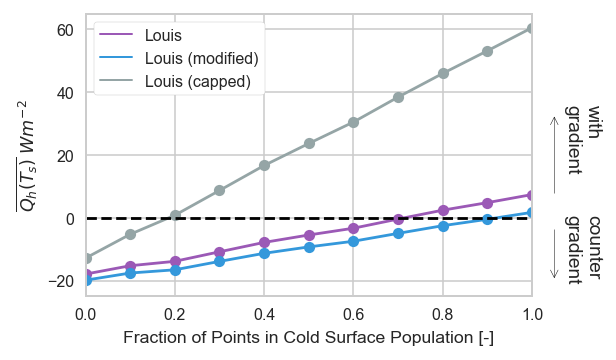

In [145]:
fig, ax = plt.subplots(1,1, figsize=(4., 2.6))
snow_fraction = np.arange(0, 1.1, 0.1)

for nstab, stab in enumerate(stab_titles):
    ax.plot(snow_fraction, sensible_fract_mean[:, nstab], '-o', color=flatui[nstab])
ax.plot([0, 1], [0, 0], 'k--')

# for nstab, stab in enumerate(stab_titles):
#     ax.plot(snow_fraction, sensible_mean_tsrf[:, nstab], '->', color=flatui[nstab])
# ax.plot([0, 1], [0, 0], 'k--')

ax.set_ylim(-25, 65)
ax.set_xlim(0, 1)
ax.set_ylabel('$\overline{Q_h(T_{s})}$ $Wm^{-2}$')
ax.set_xlabel('Fraction of Points in Cold Surface Population [-]')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color=flatui[0], lw=1, label='Louis'),
                   Line2D([0], [0], color=flatui[1], lw=1, label='Louis (modified)'),
                   Line2D([0], [0], color=flatui[2], lw=1, label='Louis (capped)')]

# Create the figure
ax.legend(handles=legend_elements, loc='upper left', frameon=True, framealpha=1)
ax.text(1.07, -10, 'counter\ngradient', rotation=-90)
ax.annotate('', xy=(1.05, 0.25), xycoords='axes fraction', xytext=(1.05, 0.05), 
            arrowprops=dict(arrowstyle="<-", color='k'))

ax.text(1.07, 25, 'with\ngradient', rotation=-90)
ax.annotate('', xy=(1.05, 0.35), xycoords='axes fraction', xytext=(1.05, 0.65), 
            arrowprops=dict(arrowstyle="<-", color='k'))

os.chdir(dir_print)
fig.savefig('CGsyn.Qh.pdf', bbox_inches='tight')

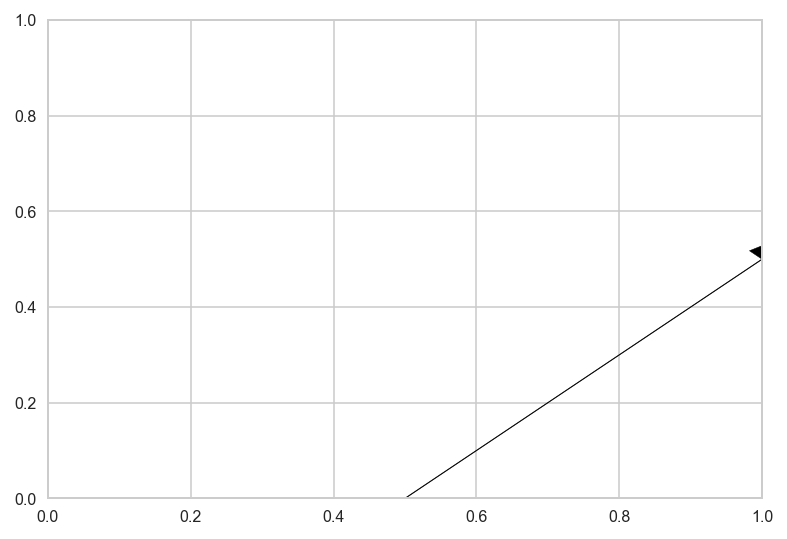

In [79]:
fig, ax = plt.subplots(1, 1)
ax.arrow(0.5, 0, 0.5, 0.5, head_width=0.05, head_length=0.1, fc='k', ec='k')

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey='row', sharex='row')

ax = axes[0]
for nstab, stab in enumerate(stab_titles):
    ax.plot(snow_fraction, sensible_fract_mean[:, nstab], '-o', label=stab, color=flatui[nstab])
ax.plot([0, 1], [0, 0], 'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('Fraction of Points in Cold Surface Population [-]')
ax.legend()
ax.set_title('a) Mean Qh from the distribution of Qh', loc='left')

ax = axes[1]
for nstab, stab in enumerate(ixStability):
    ax.plot(snow_fraction, sensible_mean_tsrf[:, nstab], '->', label=stab, color=flatui[nstab])
ax.plot([0, 1], [0, 0], 'k--')
ax.set_ylabel('Mean $Q_h Wm^{-2}$')
ax.set_xlabel('Fraction of Points in Cold Surface Population [-]')
ax.legend()
ax.set_title('b) Qh from the mean temperature', loc='left')
